In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import math
import sklearn
import sklearn.preprocessing as preprocess
from sklearn.impute import SimpleImputer
import scipy.stats as stats
from sklearn.ensemble import AdaBoostRegressor
import joblib
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# %matplotlib notebook
#補缺失值=>observation(remove outlier)=>normalize=>onehotencoding

In [2]:
# train_log = pd.read_csv("data/train_log.csv", low_memory=False)
#下載資料 進行初步的觀察
data = pd.read_csv("data/train.csv", low_memory=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4963 entries, 0 to 4962
Data columns (total 74 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4963 non-null   int64  
 1   P_ID       4963 non-null   int64  
 2   Date       4963 non-null   object 
 3   LOG ID     4963 non-null   int64  
 4   Sub. ID    4963 non-null   object 
 5   1-1_D      4321 non-null   object 
 6   1-1_M      4321 non-null   object 
 7   1-1_cell   4395 non-null   float64
 8   1-1_value  4395 non-null   float64
 9   1-2_D      4395 non-null   object 
 10  1-2_M      4395 non-null   object 
 11  1-2_cell   4395 non-null   float64
 12  1-2_value  4395 non-null   float64
 13  1-3_D      4395 non-null   object 
 14  1-3_M      4395 non-null   object 
 15  1-3_cell   4395 non-null   float64
 16  1-3_value  4395 non-null   float64
 17  2-1_D      4925 non-null   object 
 18  2-1_M      4925 non-null   object 
 19  2-1_cell   4925 non-null   float64
 20  2-1_valu

已經大略看出label的分配及偏態, 一看就是outlier


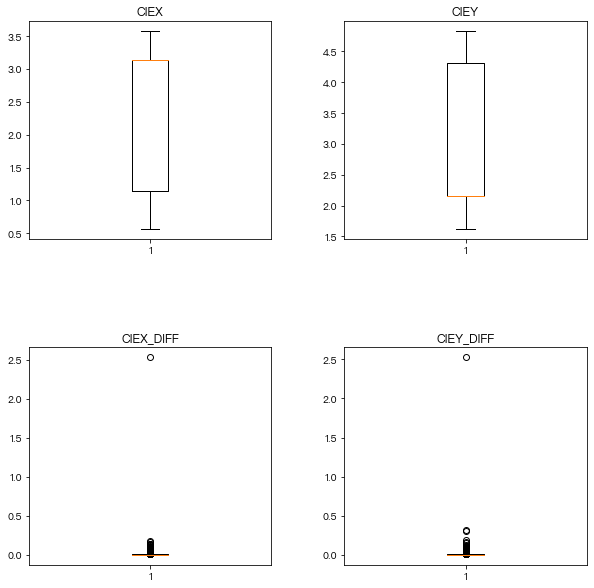

In [3]:
# import matplotlib
# print(matplotlib.__file__)
plt.rcParams['font.family']=['PingFang HK'] #用来正常显示中文标签
fig , ax = plt.subplots(figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3) #設定子圖的間隔
for i, j in zip(range(1,5), ['CIEX', 'CIEY', 'CIEX_DIFF', 'CIEY_DIFF']):
    plt.subplot(2, 2, i).set_title(j)
    plt.boxplot(data[j])
print("已經大略看出label的分配及偏態, 一看就是outlier")

In [4]:
#初步觀察資料後發現有一個離群值
#選擇刪去
# 因為那傢伙的特徵其實都很正常
# features的部分毫無任何離群值
# 因此有頗大機率是輸入錯誤
data.drop(3231, inplace = True)
data.reset_index(drop=True, inplace = True)

好多了咩噗 不過這label一堆莫名其妙的離群值


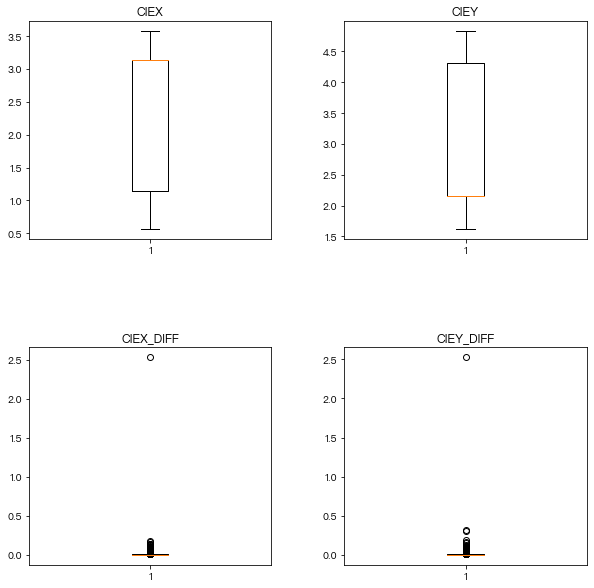

In [5]:
#再來看一次啦
plt.rcParams['font.family']=['PingFang HK'] #用来正常显示中文标签
fig , ax = plt.subplots(figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3) #設定子圖的間隔
for i, j in zip(range(1,5), ['CIEX', 'CIEY', 'CIEX_DIFF', 'CIEY_DIFF']):
    plt.subplot(2, 2, i).set_title(j)
    plt.boxplot(data[j])

print('好多了咩噗 不過這label一堆莫名其妙的離群值')

In [6]:
#把data的Xy拆開
y_train = data[['CIEX', 'CIEY', 'CIEX_DIFF', 'CIEY_DIFF']]
for co in ['CIEX', 'CIEY', 'CIEX_DIFF', 'CIEY_DIFF']:
    data.drop(columns = co, inplace = True)
X_train = data

In [7]:
#初步觀察之後發現
X_train.drop(columns='4-2_D', inplace=True)
X_train.drop(columns='4-2_M', inplace=True)
X_train.drop(columns='Date', inplace=True)
X_train.drop(columns='Sub. ID', inplace=True)

In [8]:
#來確認該砍的是不是都砍了
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4963 entries, 0 to 4962
Data columns (total 66 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4963 non-null   int64  
 1   P_ID       4963 non-null   int64  
 2   LOG ID     4963 non-null   int64  
 3   1-1_D      4321 non-null   object 
 4   1-1_M      4321 non-null   object 
 5   1-1_cell   4395 non-null   float64
 6   1-1_value  4395 non-null   float64
 7   1-2_D      4395 non-null   object 
 8   1-2_M      4395 non-null   object 
 9   1-2_cell   4395 non-null   float64
 10  1-2_value  4395 non-null   float64
 11  1-3_D      4395 non-null   object 
 12  1-3_M      4395 non-null   object 
 13  1-3_cell   4395 non-null   float64
 14  1-3_value  4395 non-null   float64
 15  2-1_D      4925 non-null   object 
 16  2-1_M      4925 non-null   object 
 17  2-1_cell   4925 non-null   float64
 18  2-1_value  4925 non-null   float64
 19  2-2_D      4925 non-null   object 
 20  2-2_M   

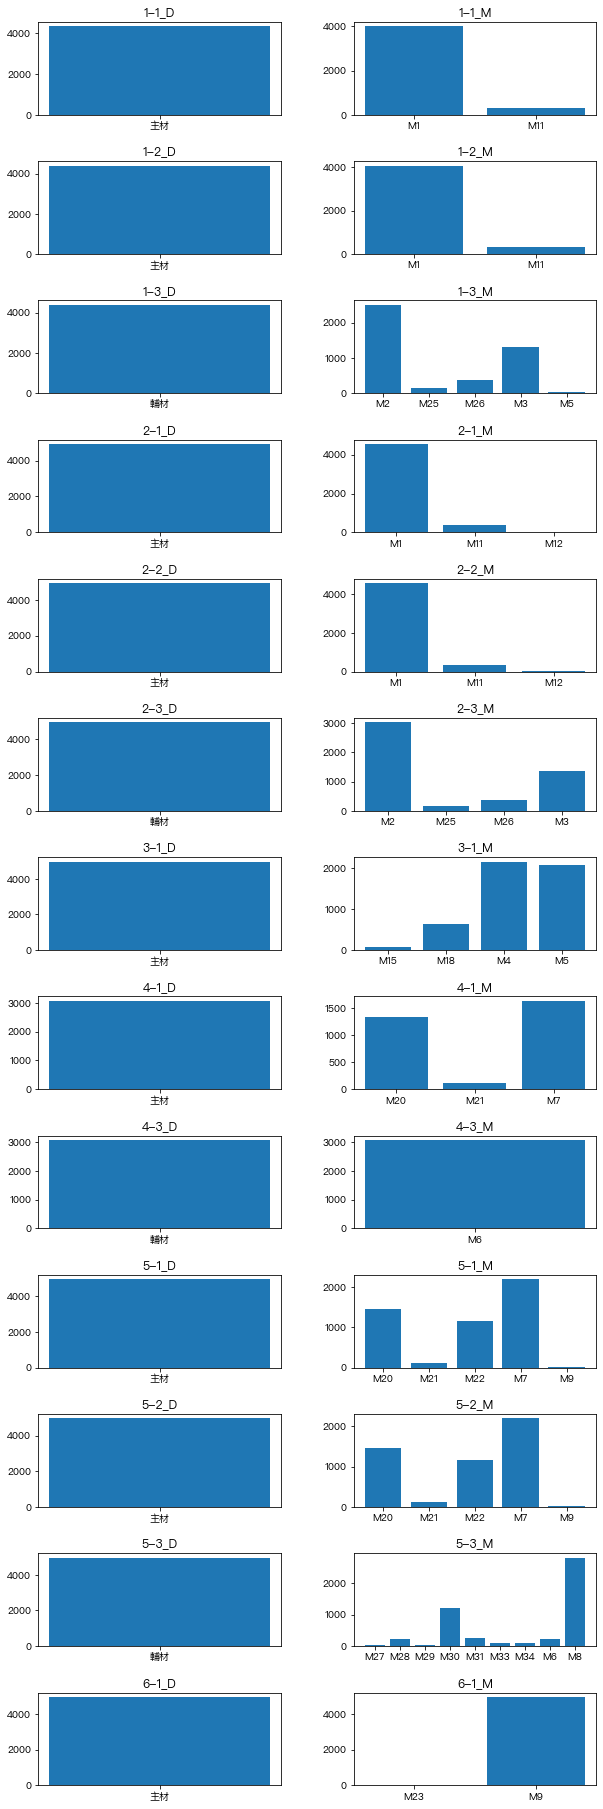

In [9]:
#接下來看看feature
cate_type = pd.Series(X_train.select_dtypes(include=['object', 'category']).columns)
#取出種類的出來畫圖
fig , ax = plt.subplots(figsize=(10,35))
fig.subplots_adjust(hspace=0.5, wspace=0.3) #設定子圖的間隔
for i, j in zip(range(1,27), cate_type):
    cate = X_train.groupby(j)
    plt.subplot(14, 2, i).set_title(j)
    plt.bar(pd.Series(cate.size()).index, pd.Series(cate.size()).values)

In [10]:
#填補缺失值
train_cate = X_train.select_dtypes(include=['object', 'category'])
cate_type = pd.Series(X_train.select_dtypes(include=['object', 'category']).columns)

train_float = X_train.select_dtypes(include=['float', 'int'])
float_type = pd.Series(X_train.select_dtypes(include=['float', 'int']).columns)

imp_mode = SimpleImputer(missing_values = np.nan, strategy="most_frequent", copy=True)
train_cate = imp_mode.fit_transform(train_cate)

imp_median = SimpleImputer(missing_values = np.nan, strategy="median", copy=True)
train_float = imp_median.fit_transform(train_float)

In [11]:
X_train[cate_type] = train_cate
X_train[float_type] = train_float

In [12]:
#if nonull that means 0
#if we sum up all values
#get 0, that means no null
su = 0
for i in X_train.isnull().sum():
    su += i

print(su)

0


In [13]:
X_train = pd.get_dummies(X_train)
print(X_train.head())

#after onehot encoding, let us check the columns
for i in X_train.columns:
    print(i, end = "")
    print(',', end = '')

    id    P_ID  LOG ID  1-1_cell  1-1_value  1-2_cell  1-2_value  1-3_cell  \
0  0.0   924.0     4.0       1.0  27.386957       1.0  25.956522       1.0   
1  1.0  1341.0     6.0       1.0  27.430435       1.0  25.913043       1.0   
2  3.0  1970.0     8.0       1.0  26.391304       1.0  24.843478       1.0   
3  6.0  4028.0    11.0       1.0  26.408696       1.0  24.882609       1.0   
4  8.0  6862.0    14.0       1.0  26.873913       1.0  25.482609       1.0   

   1-3_value  2-1_cell  ...  6-1_D_主材  6-1_M_M23  6-1_M_M9  TYPE_TYPE1  \
0  14.404348       1.0  ...         1          0         1           0   
1  14.343478       1.0  ...         1          0         1           0   
2  13.821739       1.0  ...         1          0         1           0   
3  14.047826       1.0  ...         1          0         1           0   
4  13.486957       1.0  ...         1          0         1           0   

   TYPE_TYPE2  TYPE_TYPE3  TYPE_TYPE4  TYPE_TYPE5  TYPE_TYPE6  TYPE_TYPE7  
0         

In [14]:
#after we dealed with the fatures, standardlizing all features
from sklearn.preprocessing import StandardScaler

scale = StandardScaler() #z-scaler物件
X_train[float_type] = pd.DataFrame(scale.fit_transform(X_train[float_type]),
                                columns=X_train[float_type].keys())

In [15]:
X_train.describe()

,id,P_ID,LOG ID,1-1_cell,1-1_value,1-2_cell,1-2_value,1-3_cell,1-3_value,2-1_cell,...,6-1_D_主材,6-1_M_M23,6-1_M_M9,TYPE_TYPE1,TYPE_TYPE2,TYPE_TYPE3,TYPE_TYPE4,TYPE_TYPE5,TYPE_TYPE6,TYPE_TYPE7
count,4.963000e+03,4.963000e+03,4.963000e+03,4.963000e+03,4.963000e+03,4.963000e+03,4.963000e+03,4.963000e+03,4.963000e+03,4.963000e+03,...,4963.0,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000
mean,-3.497326e-16,-7.273381e-16,-1.304171e-17,8.769039e-17,1.280996e-15,8.769039e-17,-1.114540e-15,1.173881e-14,4.563927e-16,9.523579e-16,...,1.0,0.001612,0.998388,0.228692,0.071529,0.005440,0.029418,0.021358,0.623212,0.020351
std,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,...,0.0,0.040120,0.040120,0.420033,0.257733,0.073565,0.168991,0.144589,0.484630,0.141211
min,-1.812547e+00,-1.544632e+00,-1.472989e+00,-1.479063e+00,-3.145293e+00,-1.479063e+00,-3.356827e+00,-2.264074e-01,-2.308564e+00,-1.379286e+00,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.085733e-01,-9.599981e-01,-8.671307e-01,-1.001254e+00,-2.550346e-01,-1.001254e+00,-2.840805e-01,-2.264074e-01,-3.542364e-01,-9.217976e-01,...,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.343748e-02,4.623383e-02,-1.710376e-01,4.321757e-01,-7.300025e-02,4.321757e-01,-5.270962e-02,-2.264074e-01,-1.726322e-01,4.506668e-01,...,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,8.475530e-01,9.114219e-01,7.055240e-01,4.321757e-01,7.683750e-02,4.321757e-01,2.638145e-02,-2.264074e-01,-1.243155e-01,4.506668e-01,...,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.658561e+00,1.667105e+00,3.206303e+00,1.387795e+00,8.452892e+00,1.387795e+00,8.753549e+00,4.416816e+00,9.835591e+00,1.365643e+00,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
X_train.head()

,id,P_ID,LOG ID,1-1_cell,1-1_value,1-2_cell,1-2_value,1-3_cell,1-3_value,2-1_cell,...,6-1_D_主材,6-1_M_M23,6-1_M_M9,TYPE_TYPE1,TYPE_TYPE2,TYPE_TYPE3,TYPE_TYPE4,TYPE_TYPE5,TYPE_TYPE6,TYPE_TYPE7
0,-1.812547,-1.544632,-1.434318,-1.479063,0.154852,-1.479063,-0.289983,-0.226407,0.177247,-1.379286,...,1,0,1,0,0,0,0,0,1,0
1,-1.812222,-1.544472,-1.408536,-1.479063,0.167235,-1.479063,-0.301787,-0.226407,0.153922,-1.379286,...,1,0,1,0,0,0,0,0,1,0
2,-1.811573,-1.544232,-1.382755,-1.479063,-0.128725,-1.479063,-0.592182,-0.226407,-0.046009,-1.379286,...,1,0,1,0,0,0,0,0,1,0
3,-1.810598,-1.543447,-1.344083,-1.479063,-0.123772,-1.479063,-0.581557,-0.226407,0.040628,-1.379286,...,1,0,1,0,0,0,0,0,1,0
4,-1.809948,-1.542365,-1.305412,-1.479063,0.008729,-1.479063,-0.418653,-0.226407,-0.174298,-1.379286,...,1,0,1,0,0,0,0,0,1,0


In [17]:
# #接下來看看feature
# cont_type = pd.Series(X_train.select_dtypes(include=['float']).columns)
# #取出連續的出來畫圖
# fig , ax = plt.subplots(figsize=(20,50))
# fig.subplots_adjust(hspace=0.5, wspace=0.3) #設定子圖的間隔
# for i, j in zip(range(1,76), cont_type):
#     cont = X_train[j]
#     plt.subplot(25, 3, i).set_title(j)
#     plt.hist(pd.Series(cont).values, bins=100, color='#FF8000')

In [18]:
#Now we can check the relation between every feature and label.
# cont feature vs. cont label:I use Pearson correlation


In [19]:
#save data
joblib.dump(X_train, 'data/X_train.pkl')
joblib.dump(y_train, 'data/y_train.pkl')

['data/y_train_new.pkl']

In [20]:
X_train = joblib.load('data/X_train.pkl')

In [30]:
X_train.describe()

,id,P_ID,LOG ID,1-1_cell,1-1_value,1-2_cell,1-2_value,1-3_cell,1-3_value,2-1_cell,...,6-1_D_主材,6-1_M_M23,6-1_M_M9,TYPE_TYPE1,TYPE_TYPE2,TYPE_TYPE3,TYPE_TYPE4,TYPE_TYPE5,TYPE_TYPE6,TYPE_TYPE7
count,4.963000e+03,4.963000e+03,4.963000e+03,4.963000e+03,4.963000e+03,4.963000e+03,4.963000e+03,4.963000e+03,4.963000e+03,4.963000e+03,...,4963.0,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000
mean,-3.497326e-16,-7.273381e-16,-1.304171e-17,8.769039e-17,1.280996e-15,8.769039e-17,-1.114540e-15,1.173881e-14,4.563927e-16,9.523579e-16,...,1.0,0.001612,0.998388,0.228692,0.071529,0.005440,0.029418,0.021358,0.623212,0.020351
std,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,1.000101e+00,...,0.0,0.040120,0.040120,0.420033,0.257733,0.073565,0.168991,0.144589,0.484630,0.141211
min,-1.812547e+00,-1.544632e+00,-1.472989e+00,-1.479063e+00,-3.145293e+00,-1.479063e+00,-3.356827e+00,-2.264074e-01,-2.308564e+00,-1.379286e+00,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.085733e-01,-9.599981e-01,-8.671307e-01,-1.001254e+00,-2.550346e-01,-1.001254e+00,-2.840805e-01,-2.264074e-01,-3.542364e-01,-9.217976e-01,...,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.343748e-02,4.623383e-02,-1.710376e-01,4.321757e-01,-7.300025e-02,4.321757e-01,-5.270962e-02,-2.264074e-01,-1.726322e-01,4.506668e-01,...,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,8.475530e-01,9.114219e-01,7.055240e-01,4.321757e-01,7.683750e-02,4.321757e-01,2.638145e-02,-2.264074e-01,-1.243155e-01,4.506668e-01,...,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.658561e+00,1.667105e+00,3.206303e+00,1.387795e+00,8.452892e+00,1.387795e+00,8.753549e+00,4.416816e+00,9.835591e+00,1.365643e+00,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
ind = joblib.load(f'data/CIEX_DIFF_outlier_id.pkl')
X_train.iloc[ind, :].describe()


,id,P_ID,LOG ID,1-1_cell,1-1_value,1-2_cell,1-2_value,1-3_cell,1-3_value,2-1_cell,...,6-1_D_主材,6-1_M_M23,6-1_M_M9,TYPE_TYPE1,TYPE_TYPE2,TYPE_TYPE3,TYPE_TYPE4,TYPE_TYPE5,TYPE_TYPE6,TYPE_TYPE7
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,...,88.0,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,0.249164,0.260855,0.047663,0.149834,-0.107955,0.149834,-0.106662,-0.068116,0.150571,0.039967,...,1.0,0.011364,0.988636,0.113636,0.136364,0.011364,0.056818,0.034091,0.625000,0.022727
std,0.802514,0.894987,1.046150,1.142333,0.335679,1.142333,0.300925,0.847401,1.124013,1.139854,...,0.0,0.106600,0.106600,0.319188,0.345141,0.106600,0.232822,0.182503,0.486897,0.149887
min,-1.776163,-1.507260,-1.408536,-1.479063,-1.219693,-1.479063,-1.239076,-0.226407,-1.010677,-1.379286,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.548037,-0.780499,-0.899357,-1.001254,-0.264322,-1.001254,-0.279359,-0.226407,-0.359651,-0.921798,...,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.471042,0.409302,-0.171038,0.432176,-0.073000,0.432176,-0.052710,-0.226407,-0.172632,-0.464309,...,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.825219,0.982312,0.740973,1.387795,0.069408,1.387795,0.022250,-0.226407,-0.013937,1.365643,...,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.605284,1.619063,2.832475,1.387795,0.744297,1.387795,0.674456,4.416816,5.030577,1.365643,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
